In [83]:
import numpy as np
import json
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import cv2
import shutil
from tqdm import tqdm, trange
import scipy.ndimage as ndimage

In [2]:
def black2white(img):
    img = img.copy()
    img[img == [0,0,0]] = 255
    return img

In [3]:
with open('crowd_source/selected_images (6).json', 'r') as f:
    data = json.load(f)
slide_stain ={}
for d in data:
    slide_stain[d['slide']] = d['images']
regex = re.compile(r'\d+')


In [4]:

source_files = os.listdir('rf_trained_pred/retinex/')
source_files = {regex.match(sf)[0]:sf for sf in source_files if regex.match(sf)[0] in slide_stain}
slide_id = '2030'
imgs = slide_stain[slide_id]
imgs = [imageio.imread(f'stain_sep_results/{slide_id}/{img}') for img in imgs]  

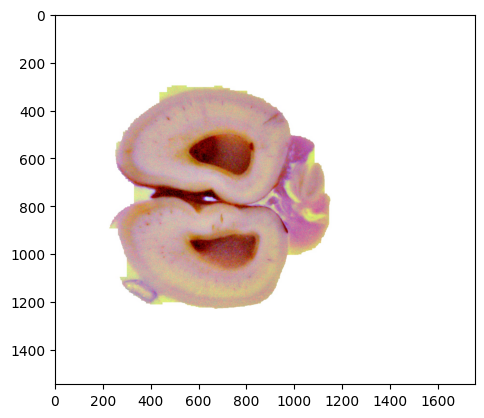

In [5]:
plt.imshow(imageio.imread(f'rf_trained_pred/retinex/{slide_id}_retinex.jpg'))

In [6]:
retinex_imgs = [cv2.imread(f'rf_trained_pred/retinex/{img}', cv2.IMREAD_GRAYSCALE) for img in tqdm(sorted(os.listdir('rf_trained_pred/retinex/'))) if regex.match(img)[0] not in ['0849','2089','1450']]
retinex_masks = [cv2.imread(f'rf_trained_pred/processed_mask/{img}', cv2.IMREAD_GRAYSCALE) for img in tqdm(sorted(os.listdir('rf_trained_pred/processed_mask/'))) if regex.match(img)[0] not in ['0849','2089','1450']]

100%|██████████| 2627/2627 [00:09<00:00, 270.40it/s]


In [7]:
def binarize_mask(mask):
    mask[mask>0] = 1
    return mask

retinex_masks = [binarize_mask(mask) for mask in tqdm(retinex_masks)]


100%|██████████| 2624/2624 [00:02<00:00, 1066.32it/s]


In [8]:
def get_percentile(slide_idx, retinex_imgs=retinex_imgs,retinex_masks=retinex_masks, p=11):
    try:
        return np.percentile(retinex_imgs[slide_idx][retinex_masks[slide_idx]==1], np.linspace(0,100,p))
    except:
        print(f'Error in slide {slide_idx}')
        return None
    # return np.percentile(retinex_imgs[slide_idx][retinex_masks[slide_idx]==1], np.linspace(0,100,11))



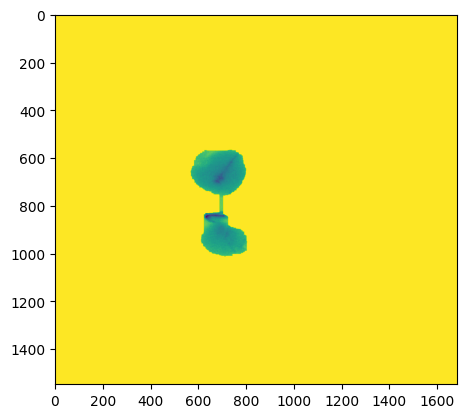

In [9]:
slide_idx=2570
# np.percentile(retinex_imgs[slide_idx][retinex_masks[slide_idx]==1], np.linspace(0,100,11))
plt.imshow(retinex_imgs[slide_idx])

In [23]:
percentiles = [get_percentile(slide_idx) for slide_idx in tqdm(range(len(retinex_imgs)))]
percentiles = [x for x in percentiles if x is not None]
percentiles = np.array(percentiles)


100%|██████████| 2624/2624 [00:31<00:00, 83.91it/s] 

Error in slide 2622


In [11]:
len(retinex_imgs)

2624

In [12]:
np.mean(percentiles, axis=0)[1]

135.34815097216926

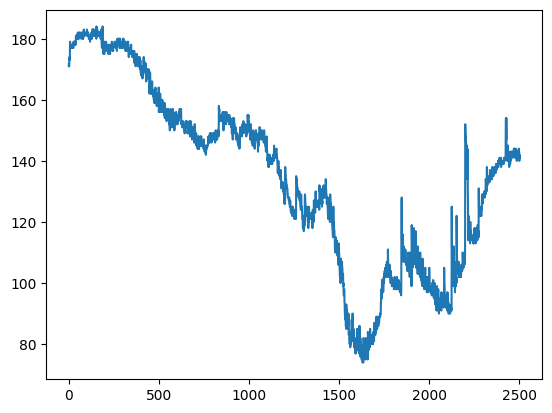

In [13]:
percentiles.shape
plt.plot(percentiles[20:-100, 1])

In [24]:
def plot_percentile_img(img, percentile):
    img = img.copy()
    img[img>percentile] = 255
    plt.imshow(img, cmap='gray')
    plt.title(f'Percentile {percentile}')
    plt.axis('off')
    plt.show()

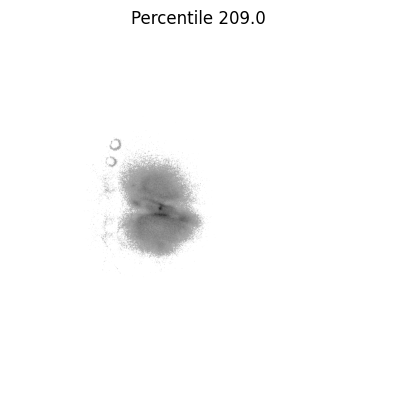

In [25]:
slide_idx = 1
plot_percentile_img(retinex_imgs[slide_idx], percentiles[slide_idx, 3])

In [26]:
### Extract all the feature Descriptors
import cv2
import cv2.xfeatures2d
from skimage import feature, exposure
import numpy as np
import torch
import traceback



DEFAULT_FEATURE_DETECTOR = cv2.BRISK_create()
"""The default OpenCV feature detector"""

MAX_FEATURES = 5000
# MAX_FEATURES = 500
"""Maximum number of image features that will be recorded. If the number
of features exceeds this value, the MAX_FEATURES features with the
highest response will be returned."""


def filter_features(kp, desc, n_keep=MAX_FEATURES):
    """Get keypoints with highest response

    Parameters
    ----------
    kp : list
        List of cv2.KeyPoint detected by an OpenCV feature detector.

    desc : ndarray
        2D numpy array of keypoint descriptors, where each row is a keypoint
        and each column a feature.

    n_keep : int
        Maximum number of features that are retained.

    Returns
    -------
    Keypoints and and corresponding descriptors that the the n_keep highest
    responses.

    """

    response = np.array([x.response for x in kp])
    keep_idx = np.argsort(response)[::-1][0:n_keep]
    return [kp[i] for i in keep_idx], desc[keep_idx, :]


class FeatureDD(object):
    """Abstract class for feature detection and description.

    User can create other feature detectors as subclasses, but each must
    return keypoint positions in xy coordinates along with the descriptors
    for each keypoint.

    Note that in some cases, such as KAZE, kp_detector can also detect
    features. However, in other cases, there may need to be a separate feature
    detector (like BRISK or ORB) and feature descriptor (like VGG).

    Attributes
    ----------
        kp_detector : object
            Keypoint detetor, by default from OpenCV

        kp_descriptor : object
            Keypoint descriptor, by default from OpenCV

        kp_detector_name : str
            Name of keypoint detector

        kp_descriptor : str
            Name of keypoint descriptor

    Methods
    -------
    detectAndCompute(image, mask=None)
        Detects and describes keypoints in image

    """

    def __init__(self, kp_detector=None, kp_descriptor=None):
        """
        Parameters
        ----------
            kp_detector : object
                Keypoint detetor, by default from OpenCV

            kp_descriptor : object
                Keypoint descriptor, by default from OpenCV

        """

        self.kp_detector = kp_detector
        self.kp_descriptor = kp_descriptor

        if kp_descriptor is not None and kp_detector is not None:
            # User provides both a detector and descriptor #
            self.kp_descriptor_name = kp_descriptor.__class__.__name__
            self.kp_detector_name = kp_detector.__class__.__name__

        if kp_descriptor is None and kp_detector is not None:
            # Will be using kp_descriptor for detectAndCompute #
            kp_descriptor = kp_detector
            kp_detector = None

        if kp_descriptor is not None and kp_detector is None:
            # User provides a descriptor, which must also be able to detect #
            self.kp_descriptor_name = kp_descriptor.__class__.__name__
            self.kp_detector_name = self.kp_descriptor_name

            try:
                _img = np.zeros((10, 10), dtype=np.uint8)
                kp_descriptor.detectAndCompute(_img, mask=None)

            except:
                traceback_msg = traceback.format_exc()
                msg = f"{self.kp_descriptor_name} unable to both detect and compute features. Setting to {DEFAULT_FEATURE_DETECTOR.__class__.__name__}"

                self.kp_detector = DEFAULT_FEATURE_DETECTOR

    def detect_and_compute(self, image, mask=None):
        """Detect the features in the image

        Detect the features in the image using the defined kp_detector, then
        describe the features using the kp_descriptor. The user can override
        this method so they don't have to use OpenCV's Keypoint class.

        Parameters
        ----------
        image : ndarray
            Image in which the features will be detected. Should be a 2D uint8
            image if using OpenCV

        mask : ndarray, optional
            Binary image with same shape as image, where foreground > 0,
            and background = 0. If provided, feature detection  will only be
            performed on the foreground.

        Returns
        -------
        kp : ndarry
            (N, 2) array positions of keypoints in xy corrdinates for N
            keypoints

        desc : ndarry
            (N, M) array containing M features for each of the N keypoints

        """

        image = exposure.rescale_intensity(image, out_range=(0, 255)).astype(np.uint8)
        if self.kp_detector is not None:
            detected_kp = self.kp_detector.detect(image)
            kp, desc = self.kp_descriptor.compute(image, detected_kp)

        else:
            kp, desc = self.kp_descriptor.detectAndCompute(image, mask=mask)

        if desc.shape[0] > MAX_FEATURES:

            kp, desc = filter_features(kp, desc)

        kp_pos_xy = np.array([k.pt for k in kp])

        return kp_pos_xy, desc

# Thin wrappers around OpenCV detectors and descriptors #


class OrbFD(FeatureDD):
    """Uses ORB for feature detection and description"""
    def __init__(self, kp_descriptor=cv2.ORB_create(MAX_FEATURES)):
        super().__init__(kp_descriptor=kp_descriptor)


class BriskFD(FeatureDD):
    """Uses BRISK for feature detection and description"""
    def __init__(self, kp_descriptor=cv2.BRISK_create()):
        super().__init__(kp_descriptor=kp_descriptor)


class KazeFD(FeatureDD):
    """Uses KAZE for feature detection and description"""
    def __init__(self, kp_descriptor=cv2.KAZE_create(extended=False)):
        super().__init__(kp_descriptor=kp_descriptor)


class AkazeFD(FeatureDD):
    """Uses AKAZE for feature detection and description"""
    def __init__(self, kp_descriptor=cv2.AKAZE_create()):
        super().__init__(kp_descriptor=kp_descriptor)
    

class SiftFD(FeatureDD):
    """Uses SIFT for feature detection and description"""
    def __init__(self, kp_descriptor=cv2.SIFT_create()):
        super().__init__(kp_descriptor=kp_descriptor)

# class SurfFD(FeatureDD):
#     """Uses SURF for feature detection and description"""
#     def __init__(self, kp_descriptor=cv2.xfeatures2d.SURF()):
#         super().__init__(kp_descriptor=kp_descriptor)


slide_idx = 1
orb_kp, orb_desc = OrbFD().detect_and_compute(retinex_imgs[slide_idx], mask=retinex_masks[slide_idx])
brisk_kp, brisk_desc = BriskFD().detect_and_compute(retinex_imgs[slide_idx], mask=retinex_masks[slide_idx])
kaze_kp, kaze_desc = KazeFD().detect_and_compute(retinex_imgs[slide_idx], mask=retinex_masks[slide_idx])
akaze_kp, akaze_desc = AkazeFD().detect_and_compute(retinex_imgs[slide_idx], mask=retinex_masks[slide_idx])


In [131]:
# Plot the detected features #

def plot_features(image, kp, title):
    """Plot the features on the image

    Parameters
    ----------
    image : ndarray
        Image on which the features are detected

    kp : ndarray
        (N, 2) array of keypoints in xy coordinates

    desc : ndarray
        (N, M) array of features for each of the N keypoints

    title : str
        Title of the plot

    """

    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    ax.scatter(kp[:, 0], kp[:, 1], s=5, c='r', marker='o')
    ax.set_title(title)
    ax.axis('off')
    plt.show()



percentiles_mu = np.mean(percentiles, axis=0)

def threshold_image(img, thresh=percentiles_mu[8]):
    img = img.copy()
    img[img>thresh] = 255
    return img

In [108]:
import dask
from dask.distributed import Client, LocalCluster
from dask import delayed

In [119]:
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 256,Total memory: 1.97 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41203,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 256
Started: Just now,Total memory: 1.97 TiB
Comm: tcp://127.0.0.1:44397,Total threads: 16
Dashboard: http://127.0.0.1:33019/status,Memory: 125.98 GiB
Nanny: tcp://127.0.0.1:36589,


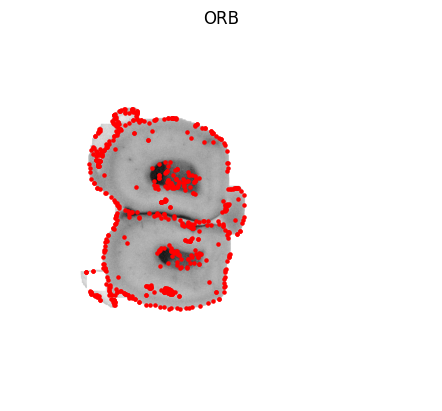

In [110]:
slide_idx = 2246
orb_kp, orb_desc = OrbFD().detect_and_compute(threshold_image(retinex_imgs[slide_idx]), mask=retinex_masks[slide_idx])
brisk_kp, brisk_desc = BriskFD().detect_and_compute(threshold_image(retinex_imgs[slide_idx]), mask=retinex_masks[slide_idx])
kaze_kp, kaze_desc = KazeFD().detect_and_compute(threshold_image(retinex_imgs[slide_idx]), mask=retinex_masks[slide_idx])
akaze_kp, akaze_desc = AkazeFD().detect_and_compute(threshold_image(retinex_imgs[slide_idx]), mask=retinex_masks[slide_idx])
sift_kp, sift_desc = SiftFD().detect_and_compute(threshold_image(retinex_imgs[slide_idx]), mask=retinex_masks[slide_idx])
plot_features(retinex_imgs[slide_idx], sift_kp, 'ORB')


In [112]:
(2600*3.5)/60

151.66666666666666

In [129]:
from skimage.feature import SIFT, ORB

# descriptor_extractor = SIFT()

# descriptor_extractor.detect_and_extract(img1)


def get_features(slide_idx, img, mask):
    orb_kp, orb_desc = OrbFD().detect_and_compute(threshold_image(img), mask)
    brisk_kp, brisk_desc = BriskFD().detect_and_compute(threshold_image(img), mask)
    kaze_kp, kaze_desc = KazeFD().detect_and_compute(threshold_image(img), mask)
    akaze_kp, akaze_desc = AkazeFD().detect_and_compute(threshold_image(img), mask)
    sift_kp, sift_desc = SiftFD().detect_and_compute(threshold_image(img), mask)

    result =  {
        slide_idx: {
            "ORB": {"kp": orb_kp, "desc": orb_desc},
            "BRISK": {"kp": brisk_kp, "desc": brisk_desc},
            "KAZE": {"kp": kaze_kp, "desc": kaze_desc},
            "AKAZE": {"kp": akaze_kp, "desc": akaze_desc},
            "SIFT": {"kp": sift_kp, "desc": sift_desc},
        }
    }
    with open(f"features/{slide_idx}_features.pkl", "wb") as f:
        pickle.dump(result, f)
    
    return result


import pickle


@delayed
def get_skimage_features(slide_idx, img):
    sift_descriptor_extractor = SIFT()
    orb_descriptor_extractor = ORB()
    sift_descriptor_extractor.detect_and_extract(img)
    orb_descriptor_extractor.detect_and_extract(img)
    sift_kp = sift_descriptor_extractor.keypoints
    sift_desc = sift_descriptor_extractor.descriptors
    orb_kp = orb_descriptor_extractor.keypoints
    orb_desc = orb_descriptor_extractor.descriptors
    with open(f"features/{slide_idx}_features.pkl", "w") as f:
        pickle.dump(
            {
                slide_idx: {
                    "ORB": {"kp": orb_kp, "desc": orb_desc},
                    "SIFT": {"kp": sift_kp, "desc": sift_desc},
                }
            },
            f,
        )
    return {
        slide_idx: {
            "ORB": {"kp": orb_kp, "desc": orb_desc},
            "SIFT": {"kp": sift_kp, "desc": sift_desc},
        }
    }

In [132]:
all_features = []
for slide_idx in trange(len(retinex_imgs)):
    try:
        result = get_features(slide_idx, threshold_image(retinex_imgs[slide_idx]), retinex_masks[slide_idx])
        all_features.append(result)
    except Exception as e:
        print(f"Error in slide {slide_idx}")
        print(e)
        continue

  1%|          | 14/2624 [00:42<2:07:30,  2.93s/it]

In [121]:
# from joblib import Parallel, delayed
os.makedirs('features', exist_ok=True)

In [122]:
tasks = [get_skimage_features(slide_idx, retinex_imgs[slide_idx]) for slide_idx in range(300)]

In [123]:
# submissions = []
# for slide_idx in trange(len(retinex_imgs)):
#     submission = client.submit(get_skimage_features, slide_idx, retinex_imgs[slide_idx])
#     submissions.append(submission)

results = client.gather(tasks)


In [124]:
final_results = client.compute(results, sync=True)

/usr/local/lib/python3.10/dist-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 722.91 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


2024-09-15 16:11:04,246 - distributed.dashboard.components.scheduler - ERROR - 'str' object has no attribute 'text'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/distributed/utils.py", line 838, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/distributed/dashboard/components/scheduler.py", line 441, in update
    self.root.title.text = title
AttributeError: 'str' object has no attribute 'text'
2024-09-15 16:11:04,275 - distributed.dashboard.components.scheduler - ERROR - 'str' object has no attribute 'text'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/distributed/utils.py", line 838, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/distributed/dashboard/components/scheduler.py", line 4708, in status_doc
    cluster_memory.update()
  File "/usr/local/lib/python3.10/dist-packages/bokeh/core/property/validation.py", line 95, in f

KeyboardInterrupt: 

(0,
 array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8))

In [12]:
os.makedirs('gray_corrected', exist_ok=True)

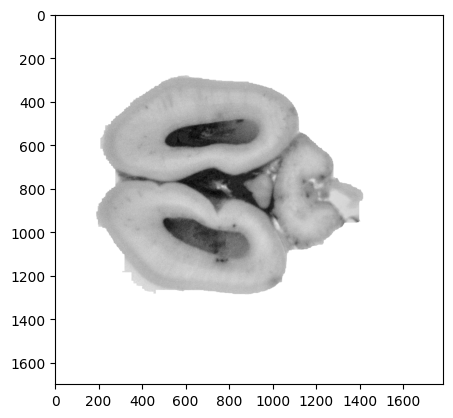

In [13]:
plt.imshow(retinex_imgs[1699], cmap='gray')

In [15]:
masks = []
for slide_idx in tqdm(range(len(retinex_imgs))):
    img = retinex_imgs[slide_idx].copy()
    # Apply the threshold
    img[img>percentiles[8]] = 255 # 80th percentile threshold
    img_threshed = img.copy()
    img_threshed = cv2.GaussianBlur(img_threshed, (15,15), 1)
    img_threshed[img_threshed<255] = 0
    img_threshed = cv2.morphologyEx(img_threshed, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=5)
    contours, _ = cv2.findContours(img_threshed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if cv2.contourArea(c)<0.9*(img_threshed.shape[0]*img_threshed.shape[1])]
    mask = np.zeros_like(img)
    mask = cv2.fillPoly(mask, contours, 1)
    cv2.imwrite(f'gray_corrected/{slide_idx}.jpg', img)
    # img = cv2.drawContours(img, contours, -1, 0, 5)
    # plt.imshow(mask, cmap='gray')
    masks.append(mask)

# img = cv2.morphologyEx(img, cv2.MORPH_CROSS, np.ones((3,3), np.uint8), iterations=5)
# img = cv2.GaussianBlur(img, (15,15), 1)
# img = cv2.dilate(img, np.ones((3,3), np.uint8), iterations=5)
# img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=5)
# img = cv2.morphologyEx(img, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=2)

100%|██████████| 2624/2624 [00:49<00:00, 52.80it/s]


In [16]:
gray_corrected = [cv2.imread(f'gray_corrected/{slide_idx}.jpg', cv2.IMREAD_GRAYSCALE) for slide_idx in tqdm(range(len(retinex_imgs)))]

100%|██████████| 2624/2624 [00:17<00:00, 151.00it/s]


#### Applying Univeral Crop to all Images

In [12]:
import scipy.ndimage as ndi

In [13]:
univ_crop_213_c = slice(1, 1584)
univ_crop_213_r = slice(172, 1382)

def apply_crop(img, r_crop, c_crop):
    return img[r_crop, c_crop]
cropped_masks = [apply_crop(mask, univ_crop_213_r, univ_crop_213_c) for mask in tqdm(masks)]
cropped_masks = [ndi.binary_fill_holes(mask) for mask in tqdm(cropped_masks)]
cropped_masks = [(255*np.ones_like(mask,dtype=np.uint8)) - mask.astype(np.uint8)*255 for mask in tqdm(cropped_masks)]


100%|██████████| 2624/2624 [00:03<00:00, 864.31it/s]


In [14]:
import ants

In [167]:
univ_crop_213_c = slice(1, 1584)
univ_crop_213_r = slice(172, 1382)

def apply_crop(img, r_crop, c_crop):
    return img[r_crop, c_crop]

cropped_masks = [apply_crop(mask, univ_crop_213_r, univ_crop_213_c) for mask in tqdm(masks)]

def ants_reg(img1, img2):
    img1 = ants.from_numpy(img1)
    img2 = ants.from_numpy(img2)
    reg = ants.registration(fixed=img1, moving=img2, type_of_transform='Rigid')
    reg_img = reg['warpedmovout']
    transform = ants.read_transform(reg['fwdtransforms'][0])
    return reg_img.numpy(), transform



100%|██████████| 2624/2624 [00:00<00:00, 1123734.30it/s]


In [15]:
import scipy.ndimage as ndi

In [16]:
os.makedirs('registered_masks', exist_ok=True)
mask_idx = 0
for mask in tqdm(cropped_masks):
    cv2.imwrite(f'registered_masks/{mask_idx}.jpg', mask)
    mask_idx+=1


100%|██████████| 2624/2624 [00:11<00:00, 229.00it/s]


In [17]:
from tqdm import trange

In [19]:
# ants.plot(ants.from_numpy(retinex_imgs[1577]), overlay=ants.from_numpy(retinex_imgs[1576]), overlay_alpha=0.5, overlay_cmap='gray')
registerred2 = []
rebb2 = []
start = ants.from_numpy(ndi.binary_fill_holes(cropped_masks[1577]).astype(np.uint8)*255)
for idx in trange(1577, 1300,-1):
    reg = ants.registration(fixed=start, moving=ants.from_numpy(ndi.binary_fill_holes(cropped_masks[idx-1]).astype(np.uint8)*255), type_of_transform='Translation')
    start = reg['warpedmovout'].numpy()
    transform = ants.read_transform(reg['fwdtransforms'][0])
    new_rebb = transform.apply_to_image(ants.from_numpy(apply_crop(retinex_imgs[idx-1], univ_crop_213_r, univ_crop_213_c))).numpy()
    rebb2.append(new_rebb)
    # start[start<=1] = 0
    registerred2.append(start)
    start = ants.from_numpy(start)
    # ants.plot(start, overlay=ants.from_numpy(new_rebb), overlay_alpha=0.5, overlay_cmap='gray')


100%|██████████| 277/277 [02:23<00:00,  1.93it/s]


In [20]:
os.makedirs(
    'fsdf', exist_ok=True
)

In [22]:
for idx, ids in enumerate(rebb2):
    cv2.imwrite(f'fsdf/{idx}.jpg', ids)

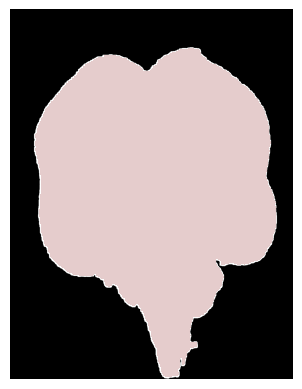

In [192]:
ants.plot(ants.from_numpy(ndi.binary_fill_holes(cropped_masks[idx-1]).astype(np.uint8)*255), overlay=ants.from_numpy(start), overlay_alpha=0.2, overlay_cmap='jet')

In [134]:
ref_idx = 1577

In [ ]:
registered_imgs = []
tranforms = []
for idx in tqdm(range(ref_idx,0,-1)):
    if idx == ref_idx:
        continue
    reg_img, transform = ants_reg(cropped_masks[idx], cropped_masks[idx-1])
    registered_img = transform.apply_to_image(ants.from_numpy(apply_crop(retinex_imgs[idx-1], univ_crop_213_r, univ_crop_213_c)))
    ants.plot(registered_img, overlay=ants.from_numpy(retinex_imgs[idx]), overlay_alpha=0.3, overlay_cmap='gray')
    break


In [143]:
os.makedirs('registered_imgs', exist_ok=True)

In [144]:
for idx, img in tqdm(enumerate(registered_imgs)):
    cv2.imwrite(f'registered_imgs/{idx}.jpg', img)

1576it [00:16, 98.47it/s] 
